กำลังโหลดและเตรียมข้อมูล...
กำลังสร้างและฝึกฝนโมเดล...
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\frame\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\frame\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1401, in run
    self.function(*self.args, **self.kwargs)
  File "c:\Users\frame\Documents\GitHub\Mini_Project\.venv\Lib\site-packages\flask_ngrok.py", line 70, in start_ngrok
    ngrok_address = _run_ngrok()
                    ^^^^^^^^^^^^
  File "c:\Users\frame\Documents\GitHub\Mini_Project\.venv\Lib\site-packages\flask_ngrok.py", line 29, in _run_ngrok
    os.chmod(executable, 777)
FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\frame\\AppData\\Local\\Temp\\ngrok\\ngrok.exe'
127.0.0.1 - - [06/Feb/2025 09:49:43] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2025 09:49:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - 

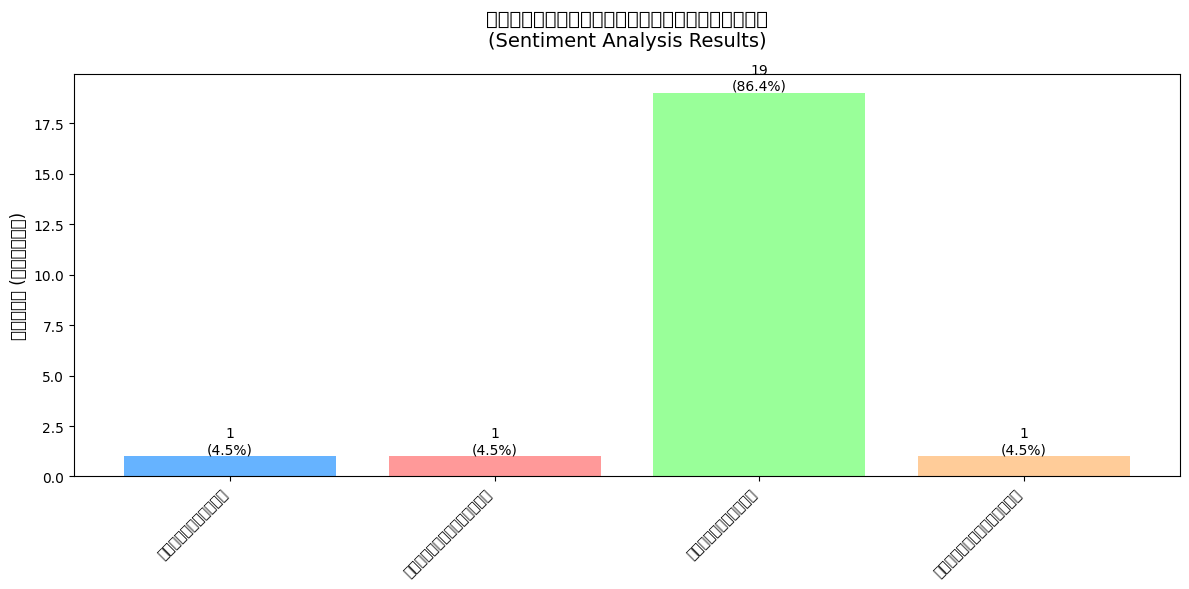

In [ ]:
from flask import Flask, request, render_template_string, send_file
from flask_ngrok import run_with_ngrok
import pandas as pd
import numpy as np
from pythainlp.tokenize import word_tokenize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from io import BytesIO
import os
import signal
import base64

def preprocess_text(text):
    """
    แปลงข้อความให้อยู่ในรูปแบบที่เหมาะสมสำหรับการวิเคราะห์
    การตัดคำที่ถูกต้องมีความสำคัญมากสำหรับการสร้าง BOW features
    """
    if text is None:
        return ""
    text = str(text)
    words = word_tokenize(text)  # ตัดคำภาษาไทยด้วย pythainlp
    text = ' '.join(words)
    text = re.sub(r'[^ก-๙a-zA-Z0-9 ]+', '', text)  # ลบอักขระพิเศษ
    return text

def create_bow_features(texts, vectorizer=None):
    """
    แปลงข้อความเป็น Bag of Words features
    สำหรับใช้กับ Gradient Boosting Classifier
    """
    if vectorizer is None:
        vectorizer = CountVectorizer(
            min_df=2,           # ใช้คำที่ปรากฏอย่างน้อย 2 ครั้ง
            max_features=5000,  # จำกัดจำนวนคำที่ใช้
            ngram_range=(1, 2)  # ใช้ทั้ง unigrams และ bigrams
        )
        features = vectorizer.fit_transform(texts)
        return features, vectorizer
    else:
        features = vectorizer.transform(texts)
        return features

def train_and_save_model(features, labels, model_path='gradient_boosting_bow_model.pkl'):
    """
    สร้างและฝึกฝนโมเดล Gradient Boosting
    บันทึกทั้งโมเดลและข้อมูลที่จำเป็นสำหรับการทำนาย
    """
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(features, labels)
    
    model_data = {
        'model': model,
        'classes': model.classes_
    }
    
    with open(model_path, 'wb') as file:
        pickle.dump(model_data, file)
    
    return model, model.classes_

def save_vectorizer(vectorizer, path='bow_vectorizer.pkl'):
    """บันทึก vectorizer สำหรับใช้แปลงข้อความใหม่"""
    with open(path, 'wb') as file:
        pickle.dump(vectorizer, file)

def save_to_file(input_text, prediction, probabilities):
    """
    บันทึกข้อความ ผลการทำนาย และความน่าจะเป็นลงในไฟล์
    เพิ่มความน่าจะเป็นเพื่อให้การวิเคราะห์ละเอียดขึ้น
    """
    with open("analysis_results.txt", "a", encoding="utf-8") as file:
        file.write(f"ข้อความ: {input_text}\n")
        file.write(f"ผลการวิเคราะห์: {prediction}\n")
        file.write(f"ความน่าจะเป็น: {probabilities}\n\n")

def count_sentiment_types(file_path):
    """
    นับจำนวนผลการวิเคราะห์แต่ละประเภท
    อ่านจากไฟล์บันทึกผลและแยกประเภทตามผลการทำนาย
    """
    sentiment_counts = {'สุขภาพกายดี': 0, 'สุขภาพกายไม่ดี': 0, 
                       'สุขภาพจิตดี': 0, 'สุขภาพจิตไม่ดี': 0}
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        for i in range(0, len(lines), 4):  # เพิ่มช่วงเป็น 4 เพราะมีบรรทัดความน่าจะเป็น
            if i + 1 < len(lines):  # ตรวจสอบว่ายังมีบรรทัดเหลืออยู่
                result_line = lines[i + 1].strip()
                for sentiment in sentiment_counts.keys():
                    if sentiment in result_line:
                        sentiment_counts[sentiment] += 1
                        break
    except FileNotFoundError:
        print(f"ไม่พบไฟล์ {file_path}")
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการอ่านไฟล์: {e}")
    
    return sentiment_counts

def plot_bar_chart(sentiment_counts):
    """
    สร้างแผนภูมิแท่งแสดงผลการวิเคราะห์
    Parameters:
        sentiment_counts (dict): Dictionary ที่เก็บจำนวนผลการวิเคราะห์แต่ละประเภท
    Returns:
        BytesIO: ไฟล์ภาพในรูปแบบ bytes
    """
    labels = list(sentiment_counts.keys())
    sizes = list(sentiment_counts.values())
    total = sum(sizes)
    
    # คำนวณเปอร์เซ็นต์
    if total == 0:
        percentages = ["0%" for _ in sizes]
    else:
        percentages = [f"{(size/total)*100:.1f}%" for size in sizes]

    # กำหนดสีสำหรับแต่ละแท่ง
    colors = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99']
    
    # สร้างกราฟ
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # สร้างแท่งกราฟ
    bars = ax.bar(labels, sizes, color=colors)
    
    # ปรับแต่งกราฟ
    ax.set_title('ผลการวิเคราะห์ความรู้สึก\n(Sentiment Analysis Results)', 
                 pad=20, fontsize=14)
    ax.set_ylabel('จำนวน (รายการ)', fontsize=12)
    
    # หมุนป้ายแกน x เพื่อให้อ่านง่าย
    plt.xticks(rotation=45, ha='right')
    
    # เพิ่มค่าตัวเลขและเปอร์เซ็นต์บนแท่งกราฟ
    for i, (bar, size, percent) in enumerate(zip(bars, sizes, percentages)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
               f'{size}\n({percent})',
               ha='center', va='bottom')
    
    # ปรับขอบกราฟให้พอดีกับเนื้อหา
    plt.tight_layout()
    
    # บันทึกกราฟเป็นไฟล์ภาพ
    img = BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight', dpi=300)
    img.seek(0)
    return img

# ฟังก์ชันที่หยุดเซิร์ฟเวอร์ Flask
def shutdown_server():
    """หยุดการทำงานของเซิร์ฟเวอร์ Flask"""
    os.kill(os.getpid(), signal.SIGINT)

# โหลดและเตรียมข้อมูล
print("กำลังโหลดและเตรียมข้อมูล...")
df = pd.read_excel('dataset.xlsx')
df['text'] = df['text'].apply(preprocess_text)

# สร้างและบันทึกโมเดล
print("กำลังสร้างและฝึกฝนโมเดล...")
features, vectorizer = create_bow_features(df['text'])
model, possible_classes = train_and_save_model(features, df['class'])
save_vectorizer(vectorizer)

# สร้าง Flask App
app = Flask(__name__)
run_with_ngrok(app)

@app.route('/')
def home():
    """หน้าหลักของเว็บแอปพลิเคชัน"""
    return render_template_string('''
        <html>
<head>
    <title>ปัญหารุมเร้า - วิเคราะห์ความรู้สึก</title>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        /* ตั้งค่าพื้นฐาน */
        :root {
            --primary-color: #4a90e2;
            --secondary-color: #45a049;
            --background-color: #f5f7fa;
            --text-color: #2c3e50;
            --border-radius: 8px;
            --box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }

        /* ตั้งค่าพื้นฐานของหน้าเว็บ */
        body {
            font-family: 'Prompt', 'Kanit', sans-serif;
            line-height: 1.6;
            margin: 0;
            padding: 0;
            background-color: var(--background-color);
            color: var(--text-color);
        }

        /* จัดการ Container หลัก */
        .container {
            max-width: 800px;
            margin: 40px auto;
            padding: 30px;
            background: white;
            border-radius: var(--border-radius);
            box-shadow: var(--box-shadow);
        }

        /* จัดการส่วนหัว */
        h1 {
            color: var(--primary-color);
            text-align: center;
            margin-bottom: 30px;
            font-size: 2.5em;
            font-weight: 600;
        }

        /* จัดการฟอร์ม */
        .form-group {
            margin-bottom: 25px;
        }

        label {
            display: block;
            margin-bottom: 8px;
            font-weight: 500;
            color: var(--text-color);
        }

        .input-field {
            width: 100%;
            padding: 12px 15px;
            border: 2px solid #e1e8ed;
            border-radius: var(--border-radius);
            font-size: 16px;
            transition: border-color 0.3s ease;
            box-sizing: border-box;
        }

        .input-field:focus {
            border-color: var(--primary-color);
            outline: none;
            box-shadow: 0 0 0 3px rgba(74, 144, 226, 0.1);
        }

        /* จัดการปุ่ม */
        .button-group {
            display: flex;
            gap: 15px;
            margin-top: 20px;
        }

        .button {
            padding: 12px 25px;
            border: none;
            border-radius: var(--border-radius);
            font-size: 16px;
            font-weight: 500;
            cursor: pointer;
            transition: all 0.3s ease;
            text-align: center;
            text-decoration: none;
            flex: 1;
        }

        .button-primary {
            background-color: var(--primary-color);
            color: white;
        }

        .button-primary:hover {
            background-color: #357abd;
            transform: translateY(-1px);
        }

        .button-secondary {
            background-color: #6c757d;
            color: white;
        }

        .button-secondary:hover {
            background-color: #5a6268;
            transform: translateY(-1px);
        }

        .button-danger {
            background-color: #dc3545;
            color: white;
        }

        .button-danger:hover {
            background-color: #c82333;
        }

        /* จัดการลิงก์ */
        .link {
            display: inline-block;
            color: var(--primary-color);
            text-decoration: none;
            margin: 20px 0;
            font-weight: 500;
            transition: color 0.3s ease;
        }

        .link:hover {
            color: #357abd;
            text-decoration: underline;
        }

        /* การตอบสนองบนอุปกรณ์มือถือ */
        @media (max-width: 768px) {
            .container {
                margin: 20px;
                padding: 20px;
            }

            h1 {
                font-size: 2em;
            }

            .button-group {
                flex-direction: column;
            }

            .button {
                width: 100%;
            }
        }

        /* เพิ่มเอฟเฟกต์การโหลด */
        @keyframes pulse {
            0% { transform: scale(1); }
            50% { transform: scale(1.05); }
            100% { transform: scale(1); }
        }

        .loading {
            animation: pulse 1.5s infinite;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>ปัญหารุมเร้า</h1>
        
        <form method="POST" action="/predict" class="form-group">
            <label for="text-input">กรอกข้อความภาษาไทย:</label>
            <input type="text" id="text-input" name="text" class="input-field" required 
                   placeholder="พิมพ์ข้อความที่ต้องการวิเคราะห์...">
            
            <div class="button-group">
                <button type="submit" class="button button-primary">วิเคราะห์</button>
                <a href="/result" class="button button-secondary">ดูผลการวิเคราะห์ทั้งหมด</a>
            </div>
        </form>

        <form method="POST" action="/shutdown" class="form-group">
            <button type="submit" class="button button-danger">ปิดเซิร์ฟเวอร์</button>
        </form>
    </div>
</body>
</html>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    """ทำนายความรู้สึกจากข้อความที่ผู้ใช้ป้อน"""
    try:
        user_text = request.form['text']
        processed_text = preprocess_text(user_text)
        
        # โหลดโมเดลและ vectorizer
        with open('gradient_boosting_bow_model.pkl', 'rb') as file:
            model_data = pickle.load(file)
            model = model_data['model']
        
        vectorizer = pickle.load(open('bow_vectorizer.pkl', 'rb'))
        
        # แปลงข้อความและทำนาย
        features = create_bow_features([processed_text], vectorizer)
        prediction = model.predict(features)[0]
        probabilities = model.predict_proba(features)[0]
        
        # จัดรูปแบบความน่าจะเป็น
        prob_str = ", ".join([f"{cls}: {prob:.2%}" 
                           for cls, prob in zip(model_data['classes'], probabilities)])
        
        # บันทึกผล
        save_to_file(user_text, prediction, prob_str)
        
        return render_template_string('''
            <div style="font-family: Poppins, sans-serif; margin: 40px;">
                <h3>ผลการวิเคราะห์: {{prediction}}</h3>
                <p>ความน่าจะเป็นแต่ละประเภท:</p>
                <p>{{probabilities}}</p>
                <br>
                <a href='/' style="color: #2196F3; text-decoration: none;">กลับหน้าหลัก</a>
            </div>
        ''', prediction=prediction, probabilities=prob_str)
        
    except Exception as e:
        return f"เกิดข้อผิดพลาด: {str(e)}"

@app.route('/result')
def result():
    """
    แสดงผลการวิเคราะห์ทั้งหมดในรูปแบบแผนภูมิวงกลม
    รวมถึงจัดการกรณีที่ยังไม่มีข้อมูลหรือเกิดข้อผิดพลาด
    """
    try:
        # ตรวจสอบว่าไฟล์ผลการวิเคราะห์มีอยู่หรือไม่
        if not os.path.exists('analysis_results.txt'):
            return render_template_string('''
                <div style="font-family: Poppins, sans-serif; margin: 40px; text-align: center;">
                    <h2>ยังไม่มีข้อมูลการวิเคราะห์</h2>
                    <p>กรุณาทำการวิเคราะห์ข้อความก่อน</p>
                    <br>
                    <a href="/" style="color: #2196F3; text-decoration: none;">กลับหน้าหลัก</a>
                </div>
            ''')

        # นับจำนวนผลการวิเคราะห์แต่ละประเภท
        sentiment_counts = count_sentiment_types('analysis_results.txt')
        
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        if sum(sentiment_counts.values()) == 0:
            return render_template_string('''
                <div style="font-family: Poppins, sans-serif; margin: 40px; text-align: center;">
                    <h2>ไม่พบข้อมูลการวิเคราะห์</h2>
                    <p>อาจเกิดจากการลบไฟล์หรือข้อมูลไม่ถูกต้อง</p>
                    <br>
                    <a href="/" style="color: #2196F3; text-decoration: none;">กลับหน้าหลัก</a>
                </div>
            ''')

        # สร้างแผนภูมิวงกลม
        img = plot_bar_chart(sentiment_counts)
        img_base64 = base64.b64encode(img.getvalue()).decode('utf-8')
        
        # แสดงผลลัพธ์
        return render_template_string('''
            <html>
            <head>
                <title>ผลการวิเคราะห์ทั้งหมด</title>
                <style>
                    body { 
                        font-family: Poppins, sans-serif; 
                        margin: 40px; 
                        text-align: center;
                        background-color: #f5f5f5;
                    }
                    .container {
                        max-width: 800px;
                        margin: 0 auto;
                        background-color: white;
                        padding: 20px;
                        border-radius: 8px;
                        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
                    }
                    .chart-container {
                        margin: 20px 0;
                    }
                    .back-button {
                        display: inline-block;
                        padding: 10px 20px;
                        background-color: #2196F3;
                        color: white;
                        text-decoration: none;
                        border-radius: 4px;
                        margin-top: 20px;
                    }
                    .back-button:hover {
                        background-color: #1976D2;
                    }
                    .stats {
                        margin: 20px 0;
                        text-align: left;
                        padding: 15px;
                        background-color: #f8f9fa;
                        border-radius: 4px;
                    }
                </style>
            </head>
            <body>
                <div class="container">
                    <h1>ผลการวิเคราะห์ทั้งหมด</h1>
                    
                    <div class="stats">
                        <h3>สรุปผลการวิเคราะห์:</h3>
                        {% for category, count in sentiment_counts.items() %}
                            <p>{{ category }}: {{ count }} รายการ</p>
                        {% endfor %}
                        <p>จำนวนรวมทั้งหมด: {{ total_count }} รายการ</p>
                    </div>

                    <div class="chart-container">
                        <img src="data:image/png;base64,{{ img_data }}" 
                             alt="Sentiment Analysis Pie Chart"
                             style="max-width: 100%; height: auto;">
                    </div>

                    <a href="/" class="back-button">กลับหน้าหลัก</a>
                </div>
            </body>
            </html>
        ''', 
        img_data=img_base64,
        sentiment_counts=sentiment_counts,
        total_count=sum(sentiment_counts.values()))
        
    except Exception as e:
        # กรณีเกิดข้อผิดพลาด
        error_message = f"เกิดข้อผิดพลาดในการแสดงผล: {str(e)}"
        return render_template_string('''
            <div style="font-family: Arial, sans-serif; margin: 40px; text-align: center;">
                <h2>เกิดข้อผิดพลาด</h2>
                <p>{{ error }}</p>
                <br>
                <a href="/" style="color: #2196F3; text-decoration: none;">กลับหน้าหลัก</a>
            </div>
        ''', error=error_message)

@app.route('/shutdown', methods=['POST'])
def shutdown():
    """ปิดเซิร์ฟเวอร์"""
    shutdown_server()
    return 'Server shutting down...'

if __name__ == '__main__':
    app.run()